**Таллин - Рига**

***Подключение библиотек, отрисовка графов***

In [ ]:
import osmnx as ox
import pandas as pd
import geopandas as gd
import networkx as nx
from scgraph.geographs.marnet import marnet_geograph

tags_port = {'industrial' : 'port'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

def func_tags(tags, city):
    try:
        gdf = ox.features_from_place(city, tags)
    except ox._errors.InsufficientResponseError:
        return None
    gdf = gdf[['name', 'geometry', 'nodes']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)
    ex = [gdf['n_osmid'].apply(lambda x: ox.geocode_to_gdf(x, by_osmid=True)[['lat', 'lon']]).iloc[:].values[x] for x in range(len(gdf))]
    dfs = pd.concat(ex, axis=0).reset_index(drop=True)
    gdf = gdf.merge(dfs, on=dfs.index)
    gdf = gdf.drop('key_0', axis=1)
    gdf = gdf[['name', 'lat', 'lon', 'geometry', 'nodes']]
    gdf['kind_of'] = list(tags.keys())[0]
    return gdf

def create_graph_city(name_city):
    full_df = pd.concat([func_tags(tags_port, name_city), 
                                    func_tags(tags_aeroway, name_city), 
                                    func_tags(tags_landuse, name_city), 
                                    func_tags(tags_build, name_city)], ignore_index=True)
    G = ox.graph_from_place(name_city, retain_all=True, simplify = True, network_type = 'drive')

    lat = list(full_df['lat'].values)
    lon = list(full_df['lon'].values)

    return full_df, G, lat, lon

def create_features_city(features_df, city_graph, lat, lon):
    features_df['new_nodes'] = ox.distance.nearest_nodes(city_graph, lon, lat)
    return features_df

def create_graph_several_city(full_graph):
    gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph)
    north, south, east, west = gdf_nodes[['y']].max(), gdf_nodes[['y']].min(), gdf_nodes[['x']].min(), gdf_nodes[['x']].max()
    full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive')
    return full_graph_from_bbox

C:\Users\orenc\AppData\Local\Temp\ipykernel_6028\2188952250.py:45: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive')
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


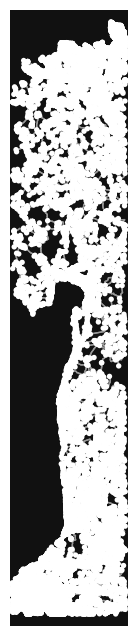

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [103]:
name_tallin = 'Tallin'
name_riga = 'Riga'

tallin = create_graph_city(name_tallin)
riga = create_graph_city(name_riga)
full_graph = nx.compose_all([tallin[1], riga[1]])
create_features_city(*riga)

ox.plot_graph(create_graph_several_city(full_graph))

 - Отрисовка коротких маршрутов от складов from до складов to - составление графа автомобильных путей
 - Отрисовка коротких маршрутов от складов до порта в обоих картах - составление графа путей до порта
 - Отрисовка коротких маршрутов от складов до ЖД-вокзалов в обоих картах - составление графа путей до ЖД
 - Отрисовка коротких маршрутов от складов до аэропортов в обоих картах - составление графа путей до аэропортов
 - Составление графа морского, ЖД и аэропути (их немного, наверно один)
 - Объединение этих графов
 - Подсчет метрик
 - Запись полученного графа в PostgreSQL

In [ ]:
def create_graph_marine(full_graph, full_df_from, full_df_to):
    list_lat_aero_from = full_df_from[full_df_from['kind_of'] == 'industrial'].lat.to_list()
    list_lon_aero_from = full_df_from[full_df_from['kind_of'] == 'industrial'].lon.to_list()
    list_lat_aero_to = full_df_to[full_df_to['kind_of'] == 'industrial'].lat.to_list()
    list_lon_aero_to = full_df_to[full_df_to['kind_of'] == 'industrial'].lon.to_list()
    full_list_lat_aero = list_lat_aero_from + list_lat_aero_to
    full_list_lon_aero = list_lon_aero_from + list_lon_aero_to
    full_df_aero = pd.DataFrame({'x' : full_list_lon_aero, 'y' : full_list_lat_aero})

    full_df_marine_x = list(full_df_aero.x)
    full_df_marine_y = list(full_df_aero.y)

    for i in range(len(full_df_marine_x)):
        for j in range(i + 1, len(full_df_marine_y)):
            output = (marnet_geograph.get_shortest_path(
                origin_node={"latitude": full_df_marine_y[i],"longitude": full_df_marine_x[i]}, 
                destination_node={"latitude": full_df_marine_y[j],"longitude": full_df_marine_x[j]}
            ))
            list_lat_marine = [output['coordinate_path'][i][0] for i in range(len(output['coordinate_path']))]
            list_lon_marine = [output['coordinate_path'][i][1] for i in range(len(output['coordinate_path']))]
            full_df_marine = pd.DataFrame({'x' : list_lon_marine, 'y' : list_lat_marine})


            full_df_marine['new_nodes'] = ox.distance.nearest_nodes(full_graph, list_lon_marine, list_lat_marine)
            full_df_marine['osmid'] = full_df_marine['new_nodes']
            full_df_marine = full_df_marine.set_index('osmid')
            edge_dict = {'u': full_df_marine.new_nodes[:-1].values, 'v': full_df_marine.new_nodes[1:].values, 'key': 0}
            edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
            edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

            graph_attrs = {"crs": "WGS84"}
            multi_digraph = ox.convert.graph_from_gdfs(
                full_df_marine, edge_gdf, graph_attrs=graph_attrs)
            
            full_graph = nx.compose_all([full_graph, multi_digraph])

    return full_graph

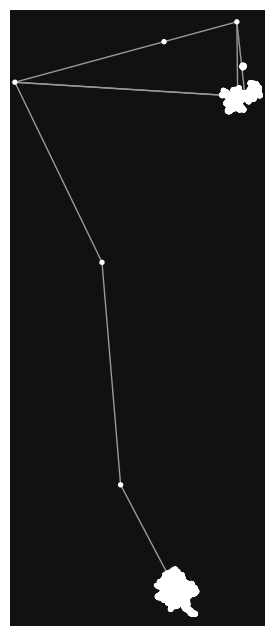

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [177]:
full_df_from = create_features_city(*tallin)
full_df_to = create_features_city(*riga)

ox.plot_graph(create_graph_marine(full_graph, full_df_from, full_df_to))

___

In [229]:
def create_df_to_graphs(kind_of, full_df_from, full_df_to):
    list_lat_aero_from = full_df_from[full_df_from['kind_of'] == kind_of].lat.to_list()
    list_lon_aero_from = full_df_from[full_df_from['kind_of'] == kind_of].lon.to_list()
    list_lat_aero_to = full_df_to[full_df_to['kind_of'] == kind_of].lat.to_list()
    list_lon_aero_to = full_df_to[full_df_to['kind_of'] == kind_of].lon.to_list()
    full_list_lat_aero = list_lat_aero_from + list_lat_aero_to
    full_list_lon_aero = list_lon_aero_from + list_lon_aero_to
    full_df_aero = pd.DataFrame({'x' : full_list_lon_aero, 'y' : full_list_lat_aero})
    return full_df_aero

def create_my_graphs(full_graph, full_df_aero):
    full_df_aero['new_nodes'] = ox.distance.nearest_nodes(full_graph, full_df_aero.x, full_df_aero.y)
    full_df_aero['osmid'] = full_df_aero['new_nodes']
    full_df_aero = full_df_aero.set_index('osmid')

    edge_dict = {'u': full_df_aero.new_nodes[:-1].values, 'v': full_df_aero.new_nodes[1:].values, 'key': 0}
    edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
    edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

    graph_attrs = {"crs": "WGS84"}
    multi_digraph_aero = ox.convert.graph_from_gdfs(
        full_df_aero, edge_gdf, graph_attrs=graph_attrs)
    
    return multi_digraph_aero

In [230]:
def create_graph_aero(full_graph, full_df_from, full_df_to):
    
    f = create_df_to_graphs('aeroway', full_df_from, full_df_to)

    multi_digraph_aero = create_my_graphs(full_graph, f)
    
    full_graph = nx.compose_all([full_graph ,multi_digraph_aero])

    return full_graph

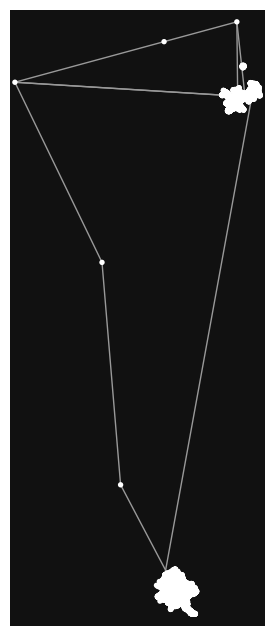

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [231]:
full_df_from = create_features_city(*tallin)
full_df_to = create_features_city(*riga)
ox.plot_graph(create_graph_aero(full_graph, full_df_from, full_df_to))

In [234]:
def create_graph_marine(full_graph, full_df_from, full_df_to):

    df_marine = create_df_to_graphs('aeroway', full_df_from, full_df_to)
    full_df_marine_x = list(df_marine.x)
    full_df_marine_y = list(df_marine.y)

    for i in range(len(full_df_marine_x)):
        for j in range(i + 1, len(full_df_marine_y)):
            output = (marnet_geograph.get_shortest_path(
                origin_node={"latitude": full_df_marine_y[i],"longitude": full_df_marine_x[i]}, 
                destination_node={"latitude": full_df_marine_y[j],"longitude": full_df_marine_x[j]}
            ))
            list_lat_marine = [output['coordinate_path'][i][0] for i in range(len(output['coordinate_path']))]
            list_lon_marine = [output['coordinate_path'][i][1] for i in range(len(output['coordinate_path']))]
            full_df_marine = pd.DataFrame({'x' : list_lon_marine, 'y' : list_lat_marine})


            multi_digraph_marine = create_my_graphs(full_graph, full_df_marine)
            
            full_graph = nx.compose_all([full_graph, multi_digraph_marine])

    return full_graph

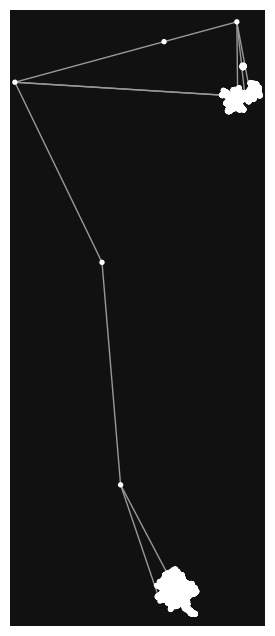

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [235]:
full_df_from = create_features_city(*tallin)
full_df_to = create_features_city(*riga)
ox.plot_graph(create_graph_marine(full_graph, full_df_from, full_df_to))